# This practice will cover learning points in Topic 2
### 1 - Fit MLR model in python with sklearn and statsmodels packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [1]:
# if you haven't installed statsmodels
! pip install statsmodels dmba

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
# DATA = Path('.').resolve().parents[1] / 'Practice/mlr'
# HOUSE_CSV = DATA / 'house_sales.csv'

HOUSE_CSV = 'house_sales.csv'

#### Data read and train-test split

In [4]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.shape, house_test.shape)

(18149, 22) (4538, 22)


In [5]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
14344,2006-12-19,650000,4206901685,Single Family,2006-12-01,423400,0.972886,668115.0,1,4000,...,2.25,3,8,1918,1992,0,335000,487000,98105,False
25226,2006-05-11,375000,9264902090,Single Family,2006-05-01,400600,0.920496,407389.0,1,8492,...,2.75,4,8,1978,0,0,72000,253000,98023,False
12322,2006-11-09,724723,3630180240,Single Family,2006-11-01,421200,0.967831,748812.0,1,5901,...,2.50,5,9,2006,0,0,288000,468000,98027,True
3198,2012-06-04,665000,1231000070,Single Family,2012-06-01,322000,0.739890,898783.0,1,3900,...,3.00,4,9,1925,2000,0,136000,465000,98118,False
4061,2008-05-21,565000,1442700430,Single Family,2008-05-01,407400,0.936121,603554.0,1,23809,...,2.50,5,9,1978,0,0,122000,316000,98038,False


In [6]:
# let's see more columns
pd.set_option('display.max_columns', 200)

In [7]:
house_test.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
11988,2009-08-03,445000,3629830220,Single Family,2009-08-01,352600,0.810202,549246.0,1,3008,1990,130,2.50,3,8,1999,0,0,272000,293000,98029,False
13871,2008-10-21,304000,4057300150,Townhouse,2008-10-01,390600,0.897518,338712.0,1,3495,1150,0,1.50,3,7,1988,0,0,200000,105000,98029,False
24389,2006-04-04,882000,8825900545,Single Family,2006-04-01,396500,0.911075,968087.0,1,5434,3020,1130,2.75,4,8,1913,0,0,420000,483000,98115,False
3745,2009-12-11,1145000,1337800390,Single Family,2009-12-01,350600,0.805607,1421289.0,1,4800,2840,800,3.00,4,9,1904,0,0,612000,557000,98112,False
20998,2006-06-13,578265,7698210090,Townhouse,2006-06-01,404400,0.929228,622307.0,1,987,1480,0,3.00,3,8,2006,0,0,170000,409000,98109,True


We can use the `LinearRegression` model from _scikit-learn_.

## 1.1 - Multiple Linear Regression (SKlearn)

In [8]:
print(house.columns)

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction'],
      dtype='object')


In [9]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
14344,668115.0,2250,4000,2.25,3,8
25226,407389.0,2330,8492,2.75,4,8
12322,748812.0,2900,5901,2.50,5,9
3198,898783.0,3480,3900,3.00,4,9
4061,603554.0,3180,23809,2.50,5,9


In [10]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -507347.796
Coefficients:
 SqFtTotLiving: 228.4548061220913
 SqFtLot: -0.022747210082657787
 Bathrooms: -22434.72633536487
 Bedrooms: -45115.728089452954
 BldgGrade: 103842.29576440387


### Assessing the Model with performance metricss
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [11]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print('Training data:')
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print('Validation data:')
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

Training data:
RMSE: 255413
r2: 0.5477
Validation data:
RMSE_test: 283418
r2_test: 0.5154


In [12]:
# correlation plot

## 1.2 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [13]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     4393.
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:02:05   Log-Likelihood:            -2.5172e+05
No. Observations:               18149   AIC:                         5.034e+05
Df Residuals:                   18143   BIC:                         5.035e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.4548      4.242     53.857

### 1.3 Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.194272   0.765463  0.596767   0.769788
SqFtLot             0.194272  1.000000   0.108496  0.068369   0.142858
Bathrooms           0.765463  0.108496   1.000000  0.536172   0.657240
Bedrooms            0.596767  0.068369   0.536172  1.000000   0.364930
BldgGrade           0.769788  0.142858   0.657240  0.364930   1.000000


[Text(0.5, 0, 'SqFtTotLiving'),
 Text(1.5, 0, 'SqFtLot'),
 Text(2.5, 0, 'Bathrooms'),
 Text(3.5, 0, 'Bedrooms'),
 Text(4.5, 0, 'BldgGrade')]

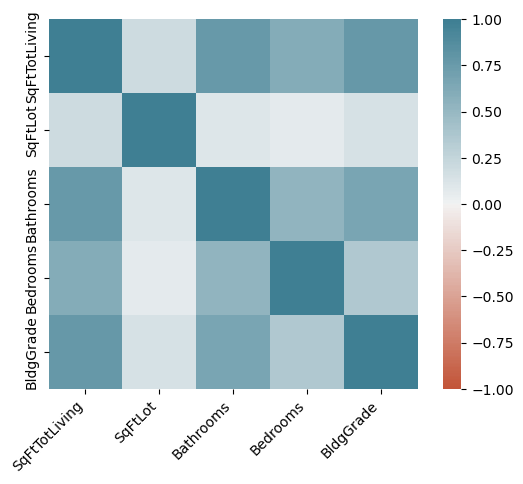

In [14]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2 - Model Selection and Stepwise Regression

In [15]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
house[predictors].head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction
14344,2250,4000,2.25,3,8,Single Family,1,0,1918,1992,False
25226,2330,8492,2.75,4,8,Single Family,1,770,1978,0,False
12322,2900,5901,2.50,5,9,Single Family,1,0,2006,0,True
3198,3480,3900,3.00,4,9,Single Family,1,1000,1925,2000,False
4061,3180,23809,2.50,5,9,Single Family,1,0,1978,0,False


In [16]:
house[predictors][house[predictors]['PropertyType']=='Multiplex']

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction
2129,1720,2410,2.00,4,7,Multiplex,2,750,1930,2006,True
287,3930,44083,4.50,7,10,Multiplex,3,1720,1992,0,False
3132,5010,7475,6.75,9,7,Multiplex,4,0,1979,0,False
372,2100,4440,2.50,3,7,Multiplex,3,0,1945,0,False
9787,2980,7243,3.00,5,7,Multiplex,2,0,1978,0,False
...,...,...,...,...,...,...,...,...,...,...,...
8567,2750,5000,3.50,6,8,Multiplex,3,940,1968,0,False
5388,1320,2582,2.00,3,8,Multiplex,2,0,1901,0,False
8571,2900,5000,4.50,6,8,Multiplex,3,780,1977,0,False
15028,1880,3880,3.00,5,8,Multiplex,2,220,1952,0,False


In [17]:
# investigate why drop_firstmno dummy variable for multiplex
#X = pd.get_dummies(house[predictors], drop_first=False) # why drop_first?
#X['PropertyType_Multiplex'].value_counts()
# house[predictors].shape
# reference is not dropped. 
#  drop_first=True is important to use, 
# as it helps in reducing the extra column created during dummy variable creation. 
# Hence it reduces the correlations created among dummy variables.

In [18]:
print("\n Predictors before nominal varibale(s) treatment: {} \n".format(house[predictors].shape))
print("PropertyType List: \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True) # why drop_first? -- no dummy variable for multiplex
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\n Predictors after nominal varibale(s) treatment: {} \n".format(X.shape))

# fit model
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())


 Predictors before nominal varibale(s) treatment: (18149, 11) 

PropertyType List: 
Single Family    16571
Townhouse         1370
Multiplex          208
Name: PropertyType, dtype: int64

 Predictors after nominal varibale(s) treatment: (18149, 12) 

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2299.
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:02:05   Log-Likelihood:            -2.5053e+05
No. Observations:               18149   AIC:                         5.011e+05
Df Residuals:                   18136   BIC:                         5.012e+05
Df Model:                          12                                         
Covariance Type:            nonrobust 

We can use the `stepwise_selection` method from the _dmba_ package.

In [19]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=517839.71, constant
Step: score=505570.90, add SqFtTotLiving
Step: score=503804.05, add BldgGrade
Step: score=501625.36, add YrBuilt
Step: score=501281.13, add Bedrooms
Step: score=501153.94, add Bathrooms
Step: score=501077.68, add PropertyType_Townhouse
Step: score=501076.06, add SqFtLot
Step: score=501075.32, add NbrLivingUnits
Step: score=501075.32, unchanged None

Intercept: 6345479.121
Coefficients:
 SqFtTotLiving: 201.4452184127707
 BldgGrade: 134057.48555941254
 YrBuilt: -3622.1446736103603
 Bedrooms: -47774.0643141462
 Bathrooms: 38510.96236717168
 PropertyType_Townhouse: 70232.30393385877
 SqFtLot: 0.12442641911911778
 NbrLivingUnits: -19129.54009256175


## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [20]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-07-26    53
2006-04-25    46
2006-06-28    46
2006-05-30    44
2006-05-22    44
              ..
2014-09-22     1
2008-06-01     1
2011-12-11     1
2014-09-18     1
2010-09-10     1
Name: DocumentDate, Length: 2461, dtype: int64


In [21]:
house['Year'] = pd.to_datetime(house['DocumentDate']).dt.year
house['Weight'] = house['Year'] - (house['Year'].min()-1)

In [22]:
# other ways to parse yewr
# house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
# house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()

In [23]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house['Weight'])
lm_wt_coeffs = pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)
lm_wt_coeffs

/var/folders/d5/0rs5hy6j79776c7g000ncxbm0000gn/T/ipykernel_84278/69977889.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lm_wt_coeffs = pd.DataFrame({


,predictor,house_lm,house_wt
0,SqFtTotLiving,228.454806,248.231578
1,SqFtLot,-0.022747,-0.155022
2,Bathrooms,-22434.726335,-28903.624812
3,Bedrooms,-45115.728089,-51174.088183
4,BldgGrade,103842.295764,111223.724609
5,intercept,-507347.796348,-563723.077370


       abs_residual_lm  abs_residual_wt  Year
14344     16617.423822      2702.739131  2006
25226    205949.688943    211559.526809  2006
12322     59140.115713     79305.731421  2006
3198      75616.785353    110341.521866  2012
4061     267958.104389    291292.435748  2008


Year   Abs_residual_lm    Abs_residual_wt
2006 139175.3721763087 145686.17482196694
2007 147537.40786418613 152995.06008327153
2008 142243.38900079136 146797.13375136274
2009 149235.8207751594 153742.6026329281
2010 162840.12556749533 165771.68080158427
2011 168324.3787091653 171731.45343057145
2012 168151.48455027104 170665.10499508778
2013 200998.97984344434 204285.44927346904
2014 186881.94427215867 189305.04611649778
2015 165477.10939226887 164488.51846073294


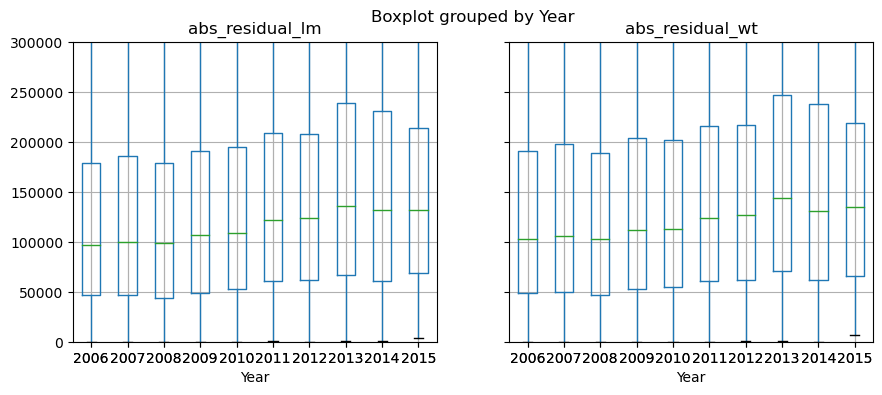

In [24]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuals. 

If we have a recent holdout sample we can test the weight could help for future prediction or not

# 4 - Regularization

In [25]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
14344           2250     4000       2.25         3          8  Single Family   
25226           2330     8492       2.75         4          8  Single Family   
12322           2900     5901       2.50         5          9  Single Family   
3198            3480     3900       3.00         4          9  Single Family   
4061            3180    23809       2.50         5          9  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
14344               1                0     1918         1992            False  
25226               1              770     1978            0            False  
12322               1                0     2006            0             True  
3198                1             1000     1925         2000            False  
4061                1                0     1978            0            False  

 PropertyType List 
Single Family    1

### Regular Multiple Regression

In [26]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

{'Intercept': 6299390.923,
 'SqFtTotLiving': 199.33,
 'SqFtLot': 0.128,
 'Bathrooms': 38375.42,
 'Bedrooms': -47969.766,
 'BldgGrade': 134829.451,
 'NbrLivingUnits': -21842.012,
 'SqFtFinBasement': 6.201,
 'YrBuilt': -3595.349,
 'YrRenovated': -1.409,
 'NewConstruction': 333.132,
 'PropertyType_Single Family': -6239.303}

In [27]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2 = r2_score(y_test, fitted_test)
print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')

regular mlr MSE: 269111
r2_test: 0.5631


### L2 - Ridge regression (Parameter shrinkage)

In [28]:
ridge_cv = RidgeCV(alphas=np.logspace(-10, 1, 400)) #normalize?
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression alpha:', ridge_cv.alpha_)
print('Ridge Regression coefficients:')
ridge_coefs

Ridge Regression MAE: 136284.186
Ridge Regression alpha: 10.0
Ridge Regression coefficients:


{'Intercept': 6299613.931,
 'SqFtTotLiving': 199.429,
 'SqFtLot': 0.128,
 'Bathrooms': 38300.186,
 'Bedrooms': -47975.763,
 'BldgGrade': 134718.917,
 'NbrLivingUnits': -23878.367,
 'SqFtFinBasement': 6.227,
 'YrBuilt': -3591.597,
 'YrRenovated': -1.35,
 'NewConstruction': 409.189,
 'PropertyType_Single Family': -10999.616}

### L1 - Lasso regression (Parameter sparsity)

In [29]:
lasso_cv = LassoCV(alphas=np.logspace(-10, 1, 400)) # normalize=True
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO alpha:', lasso_cv.alpha_)
print('LASSO coefficients:')
lasso_coefs

/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365555769705052.25, tolerance: 215739509586.2546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1320105296154.375, tolerance: 215739509586.2546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431738472502402.1, tolerance: 215739509586.2546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/

/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37905568823897.0, tolerance: 208746210236.41354
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392600964251744.6, tolerance: 208746210236.41354
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7089186759268.125, tolerance: 208746210236.41354
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt

LASSO MAE: 136295.567
LASSO alpha: 10.0
LASSO coefficients:


/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383862308847172.06, tolerance: 209307531911.89987
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373662731393718.06, tolerance: 209307531911.89987
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404168444366616.2, tolerance: 209307531911.89987
  model = cd_fast.enet_coordinate_descent_gram(
/Users/dby/

{'Intercept': 6293438.653,
 'SqFtTotLiving': 199.327,
 'SqFtLot': 0.128,
 'Bathrooms': 38311.516,
 'Bedrooms': -47967.374,
 'BldgGrade': 134836.525,
 'NbrLivingUnits': -20633.91,
 'SqFtFinBasement': 6.22,
 'YrBuilt': -3593.613,
 'YrRenovated': -1.388,
 'NewConstruction': 239.387,
 'PropertyType_Single Family': -4822.524}

# Home Work

## 1. Compare the three model fits and draw conclusion 
from the comparision of the three model fits regarding there coefficent difference

Compare linear model (mlr), weighted model, L1, L2

In [31]:
lm_wt_coeffs

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.454806,248.231578
1,SqFtLot,-0.022747,-0.155022
2,Bathrooms,-22434.726335,-28903.624812
3,Bedrooms,-45115.728089,-51174.088183
4,BldgGrade,103842.295764,111223.724609
5,intercept,-507347.796348,-563723.077370


###  Regular, L1, L2

In [65]:
pd.DataFrame({'Predictor': ['Intercept','SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction'],
              'mlr_coefs':mlr_coefs.values(),
              'ridge_coefs':ridge_coefs.values(),
              'lasso_coefs':lasso_coefs.values()})

,Predictor,mlr_coefs,ridge_coefs,lasso_coefs
0,Intercept,6299390.923,6299613.931,6293438.653
1,SqFtTotLiving,199.330,199.429,199.327
2,SqFtLot,0.128,0.128,0.128
3,Bathrooms,38375.420,38300.186,38311.516
4,Bedrooms,-47969.766,-47975.763,-47967.374
5,BldgGrade,134829.451,134718.917,134836.525
6,PropertyType,-21842.012,-23878.367,-20633.910
7,NbrLivingUnits,6.201,6.227,6.220
8,SqFtFinBasement,-3595.349,-3591.597,-3593.613
9,YrBuilt,-1.409,-1.350,-1.388


### Weighted model - worse performance than mlr

In [35]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house['Weight'])

RMSE_wt = np.sqrt(mean_squared_error(house[outcome], house_wt.predict(house[predictors])))
r2_wt = r2_score(house[outcome], house_wt.predict(house[predictors]))

print(f'RMSE_wt: {RMSE_wt}')
print(f'r2_wt: {r2_wt}')


RMSE_wt_test = np.sqrt(mean_squared_error(house_test[outcome], house_wt.predict(house_test[predictors])))
r2_wt_test = r2_score(house_test[outcome], house_wt.predict(house_test[predictors]))

print(f'RMSE_wt: {RMSE_wt_test}')
print(f'r2_wt: {r2_wt_test}')

RMSE_wt: 256193.51674620982
r2_wt: 0.5448878576663287
RMSE_wt: 282898.6666212292
r2_wt: 0.5171940142974765


## 2. Show the three model performance on both train and test

Use the `r2_score` and `RMSE`

In [73]:
import warnings
warnings.filterwarnings('ignore')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'
X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

# mlr 
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

RMSE_lm = np.sqrt(mean_squared_error(y_train, house_lm.predict(X_train)))
r2_lm = r2_score(y_train, house_lm.predict(X_train))
RMSE_lm_test = np.sqrt(mean_squared_error(y_test, house_lm.predict(X_test)))
r2_lm_test = r2_score(y_test, house_lm.predict(X_test))
print(f'RMSE_lm:{RMSE_lm}, RMSE_lm_test:{RMSE_lm_test}')
print(f'r2_lm:{r2_lm}, r2_lm_test:{r2_lm_test}\n')


# L2
ridge_cv = RidgeCV(alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)

RMSE_l2 = np.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train)))
r2_l2 = r2_score(y_train, ridge_model.predict(X_train))
RMSE_l2_test = np.sqrt(mean_squared_error(y_test, ridge_model.predict(X_test)))
r2_l2_test = r2_score(y_test, ridge_model.predict(X_test))
print(f'RMSE_l2:{RMSE_l2}, RMSE_l2_test:{RMSE_l2_test}')
print(f'r2_l2:{r2_l2}, r2_l2_test:{r2_l2_test}\n')


# L1
lasso_cv = LassoCV(alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)

RMSE_l1 = np.sqrt(mean_squared_error(y_train, lasso_model.predict(X_train)))
r2_l1 = r2_score(y_train, lasso_model.predict(X_train))
RMSE_l1_test = np.sqrt(mean_squared_error(y_test, lasso_model.predict(X_test)))
r2_l1_test = r2_score(y_test, lasso_model.predict(X_test))
print(f'RMSE_l1:{RMSE_l1}, RMSE_l1_test:{RMSE_l1_test}')
print(f'r2_l1:{r2_l1}, r2_l1_test:{r2_l1_test}\n')


RMSE_lm:239175.26550825595, RMSE_lm_test:269110.68940479826
r2_lm:0.6033434030900227, r2_lm_test:0.5631093580906448

RMSE_l2:239175.51490230093, RMSE_l2_test:269125.4054058928
r2_l2:0.6033425758820374, r2_l2_test:0.5630615750838257

RMSE_l1:239175.29718948907, RMSE_l1_test:269105.8710473833
r2_l1:0.6033432980074931, r2_l1_test:0.5631250027788808

